Author : kraemer valentin 
date : 16 nov 2023
title : vkr_nb_001.ipynb
desc : notebook personnnel valentin 

# Projet Statistiques descriptives

**packages utiles**


In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')
filelist

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_03.h5',
 '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_02.h5',
 '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_01.h5',
 '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/Aircraft_03_dask.h5']

## Chemin vers les fichiers de données :

In [2]:
ddf = lire_hdf_dask(filelist[0], repertoire= data_dir)

In [7]:
ddf.columns

Index(['ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', 'FMV_1 [mm]',
       'FMV_2 [mm]', 'HPTACC_1 [%]', 'HPTACC_2 [%]', 'M [Mach]',
       'N1_1 [% rpm]', 'N1_2 [% rpm]', 'N2_1 [% rpm]', 'N2_2 [% rpm]',
       'NAIV_1 [bool]', 'NAIV_2 [bool]', 'P0_1 [psia]', 'P0_2 [psia]',
       'PRV_1 [bool]', 'PRV_2 [bool]', 'PS3_1 [psia]', 'PS3_2 [psia]',
       'PT2_1 [mbar]', 'PT2_2 [mbar]', 'P_OIL_1 [psi]', 'P_OIL_2 [psi]',
       'Q_1 [lb/h]', 'Q_2 [lb/h]', 'T1_1 [deg C]', 'T1_2 [deg C]',
       'T2_1 [deg C]', 'T2_2 [deg C]', 'T3_1 [deg C]', 'T3_2 [deg C]',
       'T5_1 [deg C]', 'T5_2 [deg C]', 'TAT [deg C]', 'TBV_1 [%]', 'TBV_2 [%]',
       'TCASE_1 [deg C]', 'TCASE_2 [deg C]', 'TLA_1 [deg]', 'TLA_2 [deg]',
       'T_OIL_1 [deg C]', 'T_OIL_2 [deg C]', 'VBV_1 [mm]', 'VBV_2 [mm]',
       'VIB_AN1_1 [mils]', 'VIB_AN1_2 [mils]', 'VIB_AN2_1 [ips]',
       'VIB_AN2_2 [ips]', 'VIB_BN1_1 [mils]', 'VIB_BN1_2 [mils]',
       'VIB_BN2_1 [ips]', 'VIB_BN2_2 [ips]', 'VSV_1 [mm]', 'VSV_2 [mm]'],
      dtyp

In [61]:
def regression(df, formula) :
    df2 = df.copy()
    import re 
    for col in df.columns :
        newname = re.sub(r' \[.*?\]', '', col)
        df2.rename(columns={col:newname}, inplace=True)
    model = ols(formula, data = df2).fit()
    r2 = model.rsquared
    pvals = model.pvalues
    IC = model.conf_int(0.05)
    n_obs = model.nobs
    params_list = model.params
    reg_dict = {'R2' :r2, 'pvaleur' : pvals.values, 'N_observations':n_obs, 'Paramètres' : params_list.values, 'Intervals': IC.values, 'ParamName': list(params_list.index) }
    return reg_dict

In [62]:
formula = "N1_1 ~ N2_1 + T1_1 "
regression(df, formula)

{'R2': 0.8455468411716485,
 'pvaleur': array([9.48829588e-05, 0.00000000e+00, 0.00000000e+00]),
 'N_observations': 9124.0,
 'Paramètres': array([ 2.51512366,  0.98005614, -0.76979577]),
 'Intervals': array([[ 1.25260487,  3.77764244],
        [ 0.96203097,  0.99808131],
        [-0.78503534, -0.75455619]]),
 'ParamName': ['Intercept', 'N2_1', 'T1_1']}

In [64]:
formula = "N1_1 ~ N2_1 + T1_1 "
all_reg = ddf.map_partitions(lambda df : regression(df, formula)).compute()

In [74]:
all_reg[0]['ParamName']

['Intercept', 'N2_1', 'T1_1']

In [79]:
def generate_df_reg (all_reg):
    records = all_reg.index.values
    Params = all_reg[0]['ParamName']
    R2 = np.empty(len(records))
    N_obs= np.empty(len(records))
    pvals = np.empty((len(records), len(Params)))
    params_val = np.empty((len(records), len(Params)))
    IC_0 =  np.empty((len(records), len(Params)))
    IC_1 =  np.empty((len(records), len(Params)))

    for i, record in enumerate(records) :
        record_dict = all_reg[record]
        R2[i] = record_dict['R2']
        N_obs[i] = record_dict['N_observations']
        pvals[i, :] = record_dict['pvaleur']
        params_val[i, :] = record_dict['Paramètres']
        IC_0[i,:] = record_dict['Intervals'][:,0]
        IC_1[i,:] = record_dict['Intervals'][:,1]

    df_reg = pd.DataFrame({'record': records, 'R2': R2, 'N_obs': N_obs}).set_index('record')
    for i, param in enumerate(Params) :
        df_reg['coeff_'+param] = params_val[:,i]
        df_reg['pval_'+param] = pvals[:,i]
        df_reg['IC0_'+param] = IC_0[:,i]
        df_reg['IC1_'+param] = IC_1[:,i]

    return df_reg

df_reg = generate_df_reg(all_reg)


<AxesSubplot:xlabel='record'>

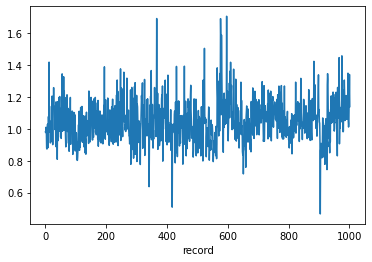

In [115]:
df_reg['coeff_N2_1'].plot()

<AxesSubplot:xlabel='record'>

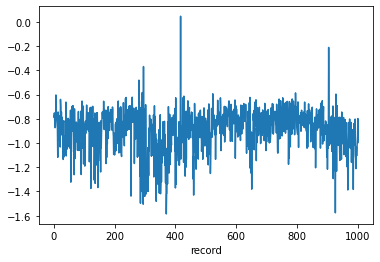

In [139]:
df_reg['IC0_T1_1'].plot()

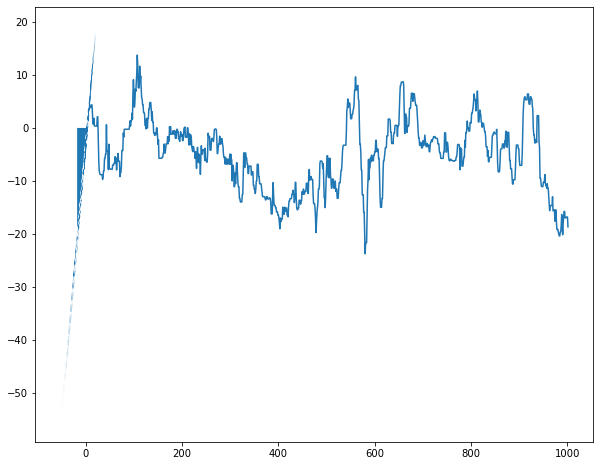

In [138]:

idx = df_reg.index.values
param = 'Intercept'
y_roll = df_reg['coeff_'+param].rolling(window=10).median().values
y_up = df_reg['IC1_'+param].values
y_down = df_reg['IC0_'+param].values

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(idx, y_roll)
ax.fill_between(y_up, y_down)

<AxesSubplot:xlabel='record'>

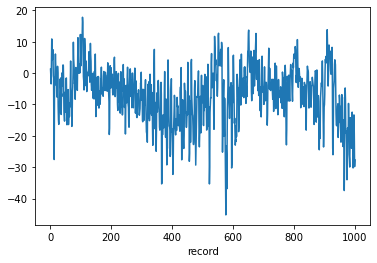

In [133]:
df_reg['IC0_Intercept'].rolling(window=2).mean().plot()

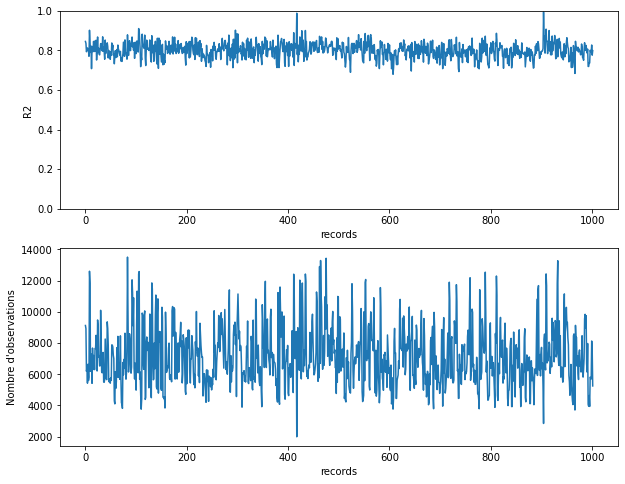

In [113]:
def afficher_significativite(df_reg) :
    records = df_reg.index.values
    fig, axs = plt.subplots(2, figsize = (10,8))
    axs[0].plot(records, df_reg['R2'].values)
    axs[1].plot(records, df_reg['N_obs'].values)
    axs[0].set_xlabel('records')
    axs[0].set_ylabel('R2')
    axs[0].set_ylim((0,1))
    axs[1].set_xlabel('records')
    axs[1].set_ylabel("Nombre d'observations")

afficher_significativite(df_reg)

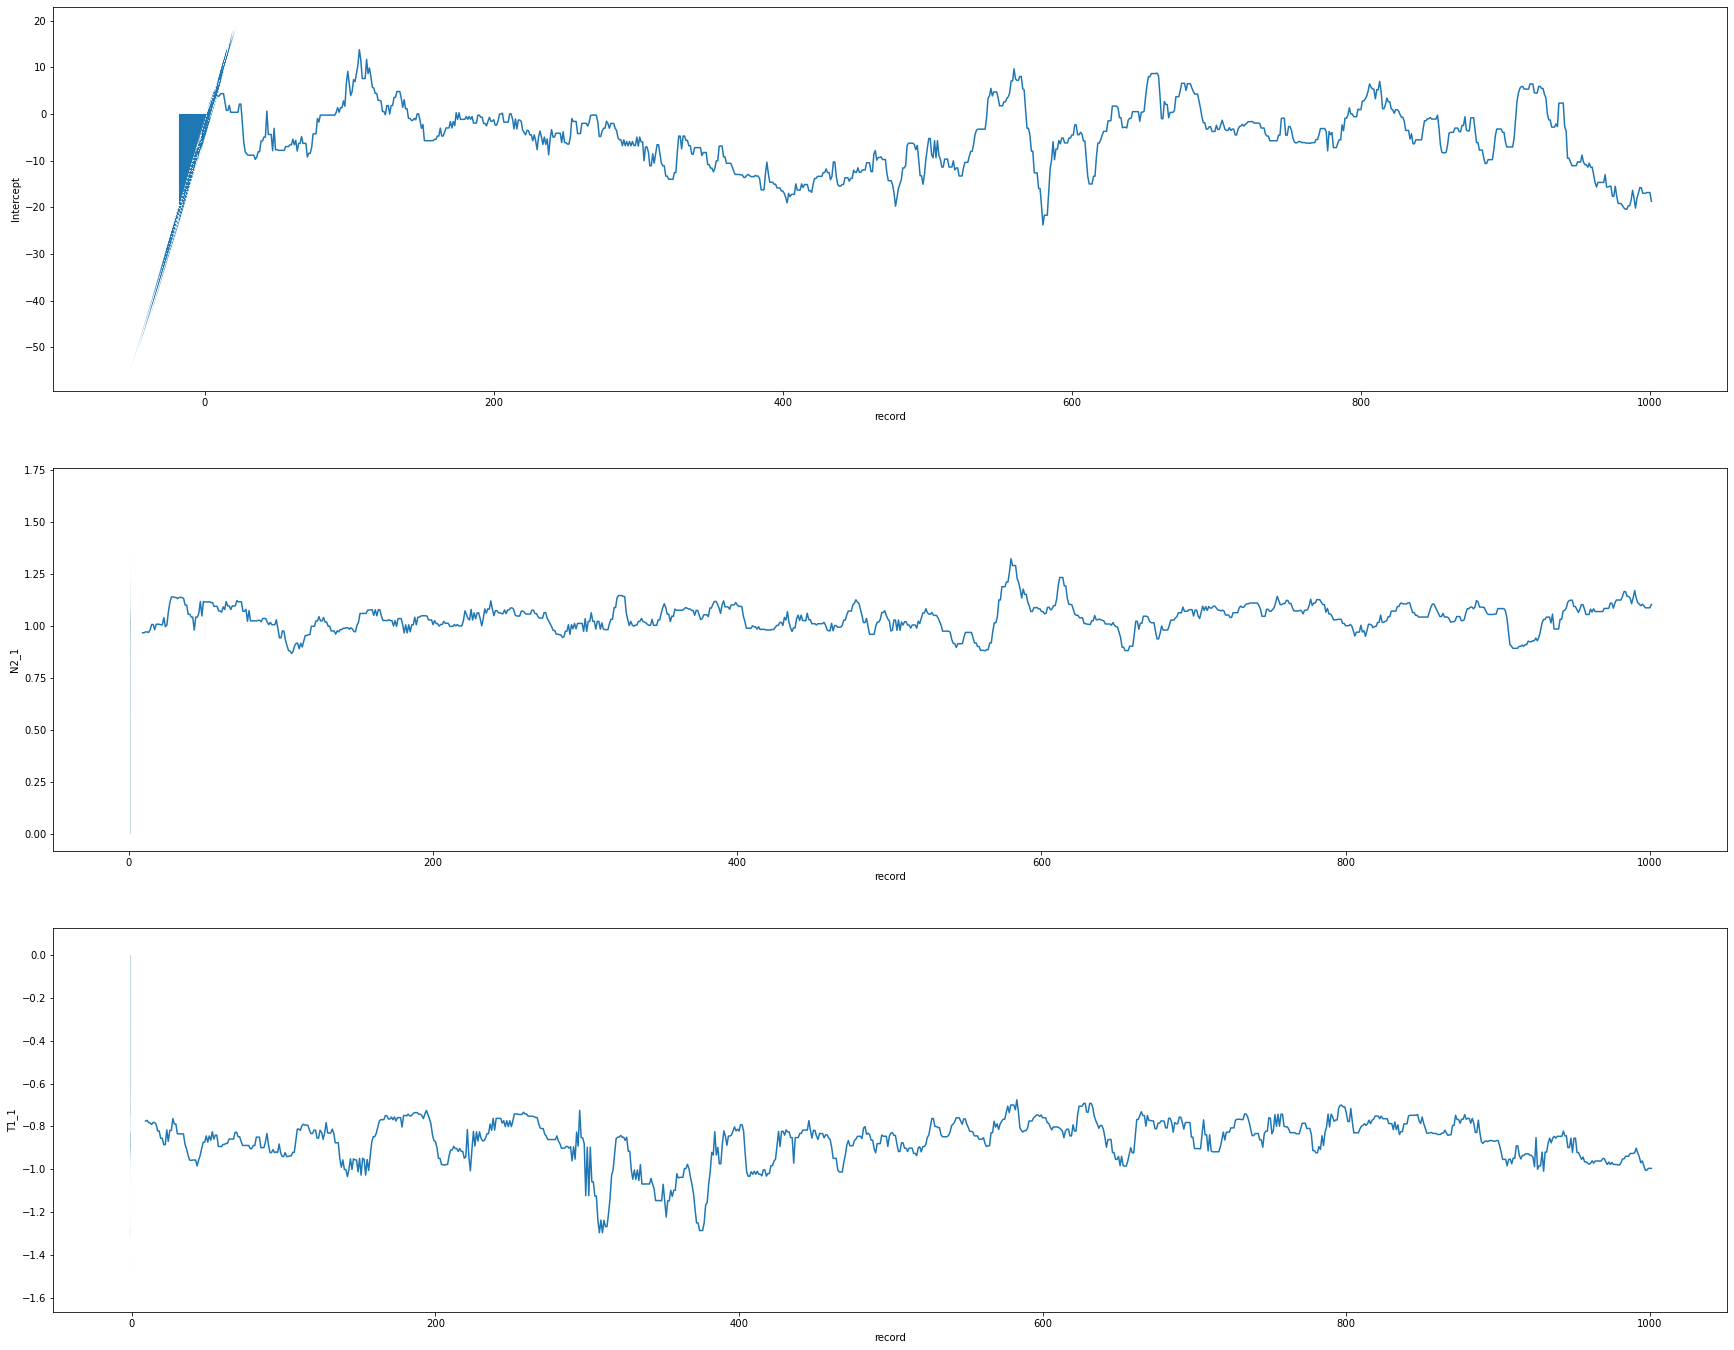

In [143]:
def afficher_coeff(df_reg,window = 10):
    l= df_reg.columns
    ParamName = [s.split('coeff_')[1] for s in l if 'coeff_' in s]
    idx = df_reg.index.values
    fig, axs = plt.subplots(len(ParamName),figsize=(len(ParamName)*10, len(ParamName)*8))
    for i,param in enumerate(ParamName) :
        ax = axs[i]
        y_roll = df_reg['coeff_'+param].rolling(window=window).median().values
        y_up = df_reg['IC1_'+param].values
        y_down = df_reg['IC0_'+param].values
        # mettre à NAN si la p_valeur depasse un certain seuil 
        ax.plot(idx, y_roll)
        ax.fill_between(y_up, y_down)
        ax.set_xlabel('record')
        ax.set_ylabel(param)

afficher_coeff(df_reg)